# Environemnt Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, brier_score_loss
from torchmetrics.classification import BinaryROC, BinaryRecall, BinaryF1Score, BinaryAUROC, BinaryPrecisionRecallCurve

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
from tqdm.auto import tqdm
from timeit import default_timer as timer 

# for reproducible results
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.determenistic=True
import random
random.seed(random_seed)
def seed_worker(worker_id):
    worker_seed = random_seed
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(random_seed)
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" #specifically required for reproducibility with CuBLABS and CUDA
os.environ["PYTHONHASHSEED"] = str(random_seed)

# Data load and pre-processing

In [2]:
import duckdb
training_dataframe = duckdb.query((f"""
select * from '{'0xB79CDBC5Cd94a807CC5cc761e3eF4A6B9baC8939_training_data.parquet'}'
where max_risk_factor < 100
""")).df().drop(columns=['withdraw_amount_sum_eth'], inplace=False)

training_cols = list(training_dataframe.columns.drop(
    ['borrow_timestamp', 'wallet_address', 'borrow_block_number', 'target']))



X_train, X_test, y_train, y_test = train_test_split(training_dataframe[training_cols].to_numpy(),
                                                    training_dataframe['target'].to_numpy(), test_size=0.2, random_state=random_seed)


sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# PyTorch

## Getting data ready for PyTorch model training

In [3]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(np.ceil(len(y) / batch_size))
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y), 1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.n_batches = n_batches

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = 42
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return self.n_batches

In [4]:
# Define custom DataLoaders
# train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainData(torch.from_numpy(X_train_scaled).type(torch.float), torch.from_numpy(y_train).type(torch.float))

# test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = TestData(torch.from_numpy(X_test_scaled).type(torch.float), torch.from_numpy(y_test).type(torch.float))

In [5]:
import os
NUM_WORKERS = 0 # use all available CPU cores
BATCH_SIZE = int(X_train.shape[0]/100) # ~1% of the training data
# initialize DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_sampler=StratifiedBatchSampler(torch.tensor(y_train), batch_size=BATCH_SIZE), 
                              worker_init_fn=seed_worker, 
                              generator=g,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             worker_init_fn=seed_worker,
                             generator=g,
                             num_workers=NUM_WORKERS)

print(f'Dataloaders: {train_dataloader, test_dataloader}') 
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')
print(f'Using number of workers: {NUM_WORKERS}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x28b6c3050>, <torch.utils.data.dataloader.DataLoader object at 0x28b6a9690>)
Length of train dataloader: 101 batches of 3438
Length of test dataloader: 26 batches of 3438
Using number of workers: 0


In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([3405, 73]), torch.Size([3405]))

In [31]:
# Check out what's inside the testing dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([3438, 73]), torch.Size([3438]))

## Helper Functions

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

In [9]:
# Get FPR, TPR and thresholds for the AUC curve
def auc_fn(y_true, y_logits):
    metric = BinaryROC(thresholds=None).to(device)
    fpr, tpr, thresholds = metric(y_logits, y_true.type(torch.int))
    J = tpr.detach().cpu().numpy() - fpr.detach().cpu().numpy()
    ix = np.argmax(J)
    best_thresh = thresholds[ix].item()
    return best_thresh

In [10]:
# Calculate recall
def recall_fn(y_true, y_pred, y_logits):
    best_thresh = auc_fn(y_true, y_logits)
    metric = BinaryRecall(threshold=best_thresh).to(device)
    return (metric(y_pred, y_true) * 100).item()

In [11]:
# Calculate F1-Score
def f1_score_fn(y_true, y_pred, y_logits):
    best_thresh = auc_fn(y_true, y_logits)
    metric = BinaryF1Score(threshold=best_thresh).to(device)
    return (metric(y_pred, y_true) * 100).item()

In [12]:
# Calculate AUROC
def auroc_fn(y_true, y_logits):
    metric = BinaryAUROC(thresholds=None).to(device)
    return (metric(y_logits, y_true) * 100).item()

In [13]:
# Calculate Brier Score
def brier_fn(y_true, y_logits):
    y_pred_probs = torch.sigmoid(y_logits)
    y_true, y_pred_probs = y_true.detach().cpu().numpy(), y_pred_probs.detach().cpu().numpy()
    return brier_score_loss(y_true, y_pred_probs) * 100

In [14]:
# Calculate AUC of the PR curve
def auc_pr_fn(y_true, y_logits):
    metric = BinaryPrecisionRecallCurve(thresholds=None).to(device)
    precision, recall, thresholds = metric(y_logits, y_true.type(torch.int))
    precision, recall = precision.detach().cpu().numpy(), recall.detach().cpu().numpy()
    return auc(recall, precision) * 100

In [15]:
# Calculate the KS-Statistic
def ks_fn(y_true, y_logits):
    y_true = pd.Series(y_true.detach().cpu().numpy())
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred_probs = pd.Series(y_pred_probs.detach().cpu().numpy())
    y_true = pd.concat([y_true, y_pred_probs], axis=1)
    y_true.columns = ['y_test_class_actual', 'y_hat_test_proba']
    y_true.sort_values('y_hat_test_proba', inplace = True)
    y_true.reset_index(drop=True, inplace=True)
    y_true['Cumulative N Population'] = y_true.index + 1
    y_true['Cumulative N Bad'] = y_true['y_test_class_actual'].cumsum()
    y_true['Cumulative N Good'] = y_true['Cumulative N Population'] - y_true['Cumulative N Bad']
    y_true['Cumulative Perc Population'] = y_true['Cumulative N Population'] / y_true.shape[0]
    y_true['Cumulative Perc Bad'] = y_true['Cumulative N Bad'] / y_true['y_test_class_actual'].sum()
    y_true['Cumulative Perc Good'] = y_true['Cumulative N Good'] / (y_true.shape[0] - y_true['y_test_class_actual'].sum())
    KS = max(y_true['Cumulative Perc Good'] - y_true['Cumulative Perc Bad'])
    
    return KS * 100

In [16]:
# Calculate the difference between the median predicted probabilities of the two classes
def prob_diff_fn(y_true, y_logits):
    y_true = pd.Series(y_true.detach().cpu().numpy())
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred_probs = pd.Series(y_pred_probs.detach().cpu().numpy())
    y_true = pd.concat([y_true, y_pred_probs], axis=1)
    y_true.columns = ['y_test_class_actual', 'y_hat_test_proba']
    prob_density_diff = y_true.loc[y_true['y_test_class_actual'] == 1, 'y_hat_test_proba'].median() - y_true.loc[y_true['y_test_class_actual'] == 0, 'y_hat_test_proba'].median()
    return prob_density_diff * 100

In [17]:
# model training function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               epochs: int,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               auc_fn,
               recall_fn,
               f1_score_fn,
               auroc_fn,
               brier_fn,
               auc_pr_fn,
               ks_fn,
               prob_diff_fn,
               device: torch.device = device):
    
    import warnings
    warnings.simplefilter('ignore')
    train_loss, train_rec, train_f1, train_auroc, train_brier, train_aucpr, train_ks, train_prob_diff = 0, 0, 0, 0, 0, 0, 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logits = model(X).squeeze() # logits
        y_pred = torch.round(torch.sigmoid(y_logits)) # predicted labels

        # 2. Calculate loss & other metrics
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_rec += recall_fn(y_true=y, y_pred=y_pred, y_logits=y_logits)
        train_f1 += f1_score_fn(y_true=y, y_pred=y_pred, y_logits=y_logits)
        train_auroc += auroc_fn(y_true=y, y_logits=y_logits)
        train_brier += brier_fn(y_true=y, y_logits=y_logits)
        train_aucpr += auc_pr_fn(y_true=y, y_logits=y_logits)
        train_ks += ks_fn(y_true=y, y_logits=y_logits)
        train_prob_diff += prob_diff_fn(y_true=y, y_logits=y_logits)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and other metrics per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_rec /= len(data_loader)
    train_f1 /= len(data_loader)
    train_auroc /= len(data_loader)
    train_brier /= len(data_loader)
    train_aucpr /= len(data_loader)
    train_ks /= len(data_loader)
    train_prob_diff /= len(data_loader)
    
    if epochs % 5 == 0:
        print(f'Training metrics:\nLoss: {train_loss:.5f} | Recall: {train_rec:.2f}% | F1-Score: {train_f1:.2f}% | AUROC: {train_auroc:.2f}% | Brier Score: {train_brier:.2f}% | AUC PR: {train_aucpr:.2f}% | KS-Statistic: {train_ks:.2f}% | Pred Prob Diff: {train_prob_diff:.2f}%')
    return {'loss': train_loss.item(),
            'recall': train_rec,
            'f1': train_f1,
            'auroc': train_auroc,
            'brier': train_brier,
            'aucpr': train_aucpr,
            'ks': train_ks,
            'prob_diff': train_prob_diff}

In [18]:
# model testing function
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              epochs: int,
              auc_fn,
              recall_fn,
              f1_score_fn,
              auroc_fn,
              brier_fn,
              auc_pr_fn,
              ks_fn,
              prob_diff_fn,
              device: torch.device = device):
    import warnings
    warnings.simplefilter('ignore')
    test_loss, test_rec, test_f1, test_auroc, test_brier, test_aucpr, test_ks, test_prob_diff = 0, 0, 0, 0, 0, 0, 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            y_logits = model(X).squeeze() # logits
            y_pred = torch.round(torch.sigmoid(y_logits)) # predicted labels
            
            # 2. Calculate loss and other metrics
            test_loss += loss_fn(y_logits, y)
            test_rec += recall_fn(y_true=y, y_pred=y_pred, y_logits=y_logits)
            test_f1 += f1_score_fn(y_true=y, y_pred=y_pred, y_logits=y_logits)
            test_auroc += auroc_fn(y_true=y, y_logits=y_logits)
            test_brier += brier_fn(y_true=y, y_logits=y_logits)
            test_aucpr += auc_pr_fn(y_true=y, y_logits=y_logits)
            test_ks += ks_fn(y_true=y, y_logits=y_logits)
            test_prob_diff += prob_diff_fn(y_true=y, y_logits=y_logits)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_rec /= len(data_loader)
        test_f1 /= len(data_loader)
        test_auroc /= len(data_loader)
        test_brier /= len(data_loader)
        test_aucpr /= len(data_loader)
        test_ks /= len(data_loader)
        test_prob_diff /= len(data_loader)
        
        if epochs % 5 == 0:
            print(f'Testing metrics:\nLoss: {test_loss:.5f} | Recall: {test_rec:.2f}% | F1-Score: {test_f1:.2f}% | AUROC: {test_auroc:.2f}% | Brier Score: {test_brier:.2f}% | AUC PR: {test_aucpr:.2f}% | KS-Statistic: {test_ks:.2f}% | Pred Prob Diff: {test_prob_diff:.2f}%')
        return {'loss': test_loss.item(),
                'recall': test_rec,
                'f1': test_f1,
                'auroc': test_auroc,
                'brier': test_brier,
                'aucpr': test_aucpr,
                'ks': test_ks,
                'prob_diff': test_prob_diff}

In [19]:
# model evaluation/validation function
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               auc_fn,
               recall_fn,
               f1_score_fn,
               auroc_fn,
               brier_fn,
               auc_pr_fn,
               ks_fn,
               prob_diff_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        other model validation metrics
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    import warnings
    warnings.simplefilter('ignore')
    loss, rec, f1, auroc, brier, aucpr, ks, prob_diff = 0, 0, 0, 0, 0, 0, 0, 0
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_logits = model(X).squeeze() # logits
            y_pred = torch.round(torch.sigmoid(y_logits)) # predicted labels
            
            # Accumulate the loss and other metrics values per batch
            loss += loss_fn(y_logits, y)
            rec += recall_fn(y_true=y, y_pred=y_pred, y_logits=y_logits)
            f1 += f1_score_fn(y_true=y, y_pred=y_pred, y_logits=y_logits)
            auroc += auroc_fn(y_true=y, y_logits=y_logits)
            brier += brier_fn(y_true=y, y_logits=y_logits)
            aucpr += auc_pr_fn(y_true=y, y_logits=y_logits)
            ks += ks_fn(y_true=y, y_logits=y_logits)
            prob_diff += prob_diff_fn(y_true=y, y_logits=y_logits)
        
        # Scale loss and other metrics to find the averages per batch
        loss /= len(data_loader)
        rec /= len(data_loader)
        f1 /= len(data_loader)
        auroc /= len(data_loader)
        brier /= len(data_loader)
        aucpr /= len(data_loader)
        ks /= len(data_loader)
        prob_diff /= len(data_loader)
        
    return {'model_name': model.__class__.__name__, # only works when model was created with a class and is not compiled
            'model_loss': loss.item(),
            'model_rec': rec,
            'model_f1': f1,
            'model_auroc': auroc,
            'model_brier': brier,
            'model_aucpr': aucpr,
            'model_ks': ks,
            'model_prob_diff': prob_diff}

In [20]:
# Plot the loss curves
def plot_loss_curves(epoch_count, train_loss_values, test_loss_values):
    plt.plot(epoch_count, train_loss_values, label='Train loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.title('Training and test loss curves')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend();

In [21]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        # number of epochs to allow for no improvement before stopping the execution
        self.patience = patience  
        # the minimum change to be counted as improvement
        self.min_delta = min_delta  
        # count the number of times the validation accuracy not improving
        self.counter = 0  
        self.min_validation_loss = np.inf

    # return True when encountering _patience_ times decrease in validation loss 
    def early_stop_check(self, validation_loss):
        if ((validation_loss + self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            # reset the counter if validation loss decreased at least by min_delta
            self.counter = 0  
        elif ((validation_loss + self.min_delta) > self.min_validation_loss):
            # increase the counter if validation loss is not decreased by the min_delta
            self.counter += 1 
            if self.counter >= self.patience:
                return True
        return False

### One hidden layer with ReLU activation

In [22]:
# define NN architecture
class PredictLiquidationsV1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p = 0.4),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# instantiate the model
model_1 = PredictLiquidationsV1(input_features=X_train.shape[1],
                                output_features=1,
                                hidden_units=82).to(device)
model_1

PredictLiquidationsV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=73, out_features=82, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=82, out_features=82, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=82, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [23]:
early_stopper = ValidationLossEarlyStopping(patience=1, min_delta=0.0)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((y_train==0).sum()/y_train.sum()).type(torch.float))
optimizer = optim.Adam(params=model_1.parameters(),
                       lr=0.001,
                       weight_decay=0.01)

In [24]:
compiled_model_1 = torch.compile(model_1)

In [25]:
# Measure time
train_time_start = timer()

epochs = 30

# Create empty loss lists to track values
model_1_train_loss_values = []
model_1_test_loss_values = []
model_1_epoch_count = []

for epoch in tqdm(range(epochs)):
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}\n---------")
    train_metrics = train_step(data_loader=train_dataloader, 
                               model=compiled_model_1, 
                               epochs=epoch,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               auc_fn=auc_fn,
                               recall_fn=recall_fn,
                               f1_score_fn=f1_score_fn,
                               auroc_fn=auroc_fn,
                               brier_fn=brier_fn,
                               auc_pr_fn=auc_pr_fn,
                               ks_fn=ks_fn,
                               prob_diff_fn=prob_diff_fn
    )
    test_metrics = test_step(data_loader=test_dataloader,
                             model=compiled_model_1,
                             epochs=epoch,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn
    )
    model_1_epoch_count.append(epoch)
    model_1_train_loss_values.append(train_metrics['loss'])
    model_1_test_loss_values.append(test_metrics['loss'])
    
    if early_stopper.early_stop_check(test_metrics['loss']):
        print(f"Stopped early at epoch: {epoch}\n---------")
        print(f"Training metrics:\nLoss: {train_metrics['loss']:.5f} | Recall: {train_metrics['recall']:.2f}% | F1-Score: {train_metrics['f1']:.2f}% | AUROC: {train_metrics['auroc']:.2f}% | Brier Score: {train_metrics['brier']:.2f}% | AUC PR: {train_metrics['aucpr']:.2f}% | KS-Statistic: {train_metrics['ks']:.2f}% | Pred Prob Diff: {train_metrics['prob_diff']:.2f}%")
        print(f"Testing metrics:\nLoss: {test_metrics['loss']:.5f} | Recall: {test_metrics['recall']:.2f}% | F1-Score: {test_metrics['f1']:.2f}% | AUROC: {test_metrics['auroc']:.2f}% | Brier Score: {test_metrics['brier']:.2f}% | AUC PR: {test_metrics['aucpr']:.2f}% | KS-Statistic: {test_metrics['ks']:.2f}% | Pred Prob Diff: {test_metrics['prob_diff']:.2f}%")
        break

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Training metrics:
Loss: 0.84982 | Recall: 100.00% | F1-Score: 55.65% | AUROC: 67.49% | Brier Score: 26.70% | AUC PR: 60.96% | KS-Statistic: 28.55% | Pred Prob Diff: 1.91%
Testing metrics:
Loss: 0.80730 | Recall: 100.00% | F1-Score: 56.38% | AUROC: 77.43% | Brier Score: 24.41% | AUC PR: 74.56% | KS-Statistic: 47.45% | Pred Prob Diff: 6.22%
Epoch: 5
---------
Training metrics:
Loss: 0.76817 | Recall: 100.00% | F1-Score: 55.67% | AUROC: 77.69% | Brier Score: 23.31% | AUC PR: 76.83% | KS-Statistic: 49.34% | Pred Prob Diff: 13.15%
Testing metrics:
Loss: 0.76560 | Recall: 100.00% | F1-Score: 56.40% | AUROC: 78.48% | Brier Score: 23.13% | AUC PR: 77.61% | KS-Statistic: 51.34% | Pred Prob Diff: 13.49%
Stopped early at epoch: 8
---------
Training metrics:
Loss: 0.76815 | Recall: 100.00% | F1-Score: 55.67% | AUROC: 77.69% | Brier Score: 23.31% | AUC PR: 76.84% | KS-Statistic: 49.35% | Pred Prob Diff: 13.15%
Testing metrics:
Loss: 0.76560 | Recall: 100.00% | F1-Score: 56.40% | 

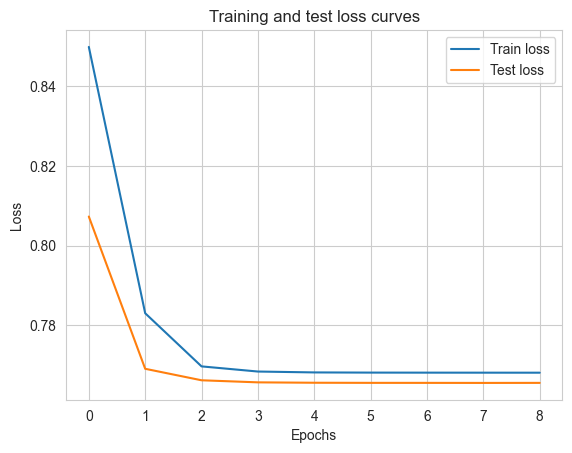

In [26]:
plot_loss_curves(model_1_epoch_count, model_1_train_loss_values, model_1_test_loss_values)

In [27]:
# Calculate model 1 results
model_1_results = eval_model(model=compiled_model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             auc_fn=auc_fn,
                             recall_fn=recall_fn,
                             f1_score_fn=f1_score_fn,
                             auroc_fn=auroc_fn,
                             brier_fn=brier_fn,
                             auc_pr_fn=auc_pr_fn,
                             ks_fn=ks_fn,
                             prob_diff_fn=prob_diff_fn,
                             device=device)
model_1_results.update({'model_name': model_1.__class__.__name__})

In [28]:
model_1_results

{'model_name': 'PredictLiquidationsV1',
 'model_loss': 0.7655976414680481,
 'model_rec': 100.0,
 'model_f1': 56.401530926044174,
 'model_auroc': 78.49808560884915,
 'model_brier': 23.13979254894247,
 'model_aucpr': 77.62280060694768,
 'model_ks': 51.328733882741524,
 'model_prob_diff': 13.52602312198052}

# Export to ONNX

In [29]:
model_1.eval()
torch.onnx.export(model_1,
                  torch.randn((1,X_train.shape[1]), requires_grad = True).to(device),
                  'models/onnx/model_1.onnx',
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes = {'input' : {0 : 'batch_size'}, 
                                  'output' : {0 : 'batch_size'}})

In [32]:
x = next(iter(test_features_batch)).numpy().tolist()

data = dict(input_data = [x])
json.dump(data, open('proofs/model_1_input.json', 'w'))